# S-wave scattering phase shifts

In [92]:
from scipy.integrate import odeint
from scipy.special import struve, yn, riccati_jn, riccati_yn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### SI units

In [95]:
# SI units
N = 1024 # number of points
hbar = 1.0545718e-34 # [Js]
eV = 1.602176634e-19 # [J]
meV = 1e-3 * eV
e_charge = 1.60217662e-19 # [C]
au = 1.64877727436e-41 # [C^2 m^2 J^(-1)] 

angstrom = 1e-10 # [m]
R = angstrom
# excluding r = 0 to avoid division by zero
r = np.linspace(1e-6, 100, N) * angstrom

### Parameters form tables 1 and 2

In [108]:
# table 1.
r_0 = 44.6814 * angstrom # [m]
mass_e = 9.10938356e-31 # [kg]
mass_eff_e = 0.47 * mass_e 
mass_eff_h = 0.54  * mass_e
mass_X = mass_eff_e + mass_eff_h
M_red = mass_eff_e * mass_X / (mass_eff_e + mass_X) 
print('The reduced mass:', M_red / mass_e)

# table 2
r_star = 34 * angstrom # only symmetric phase shift
v_0 = -58.5 * meV
alpha = 52 * (10**3) * au 
print('The polarisability:',alpha)

The reduced mass: 0.3207432432432432
The polarisability: 8.573641826672e-37


### Energy and wave vector

In [97]:
E_min = 0.1 * meV
E_max = 60 * meV
E = np.linspace(E_min, E_max, N)
k = np.sqrt(2 * M_red * E) / hbar

# IV Electron-exciton scattering
### (Schmidt et al.)

In [112]:
# au = 1.64877727436e-41 / eV # [C^2 m^2] 
# alpha = 52 * 10**3 * au

epsilon = 8.854e-12 

def keldysh(r):
    # equation (2) 
    # [V]
    V_K = (np.pi / (2 * (4 * np.pi * epsilon) * r_0) * (struve(0, r / r_0) - yn(0, r / r_0)))
    return V_K

def V_Xe(r): 
    # equation (8)
    # [J]    
    r = np.array(r)
    dr = r_0 / 1000
    V_Xe = np.zeros_like(r)
    V_Xe[r <= r_star] = v_0 
    V_Xe[r > r_star] = - (alpha * e_charge **2 / 2) * ((keldysh(r[r > r_star] + dr) - keldysh(r[r > r_star])) / dr)**2
    return V_Xe

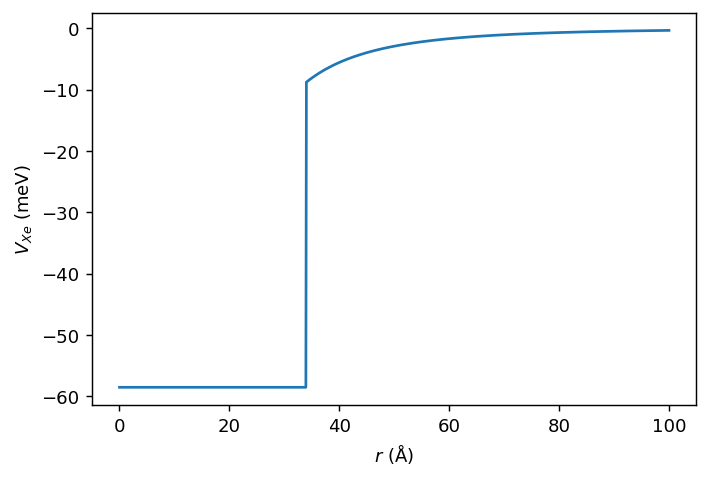

In [113]:
plt.plot(r / angstrom, V_Xe(r) / meV)
ylabel = plt.ylabel(r'$V_{Xe}$ (meV)', fontsize=10)
plt.xlabel(r'$r$ (Å)')
plt.savefig('V_Xe_Schmidt.png')
plt.show()

### BOUND STATES

for the time being, assume ($\ell = 0$)

To find the bound states of our potential, solve the radial Schrodinger wave equation:
 $\frac{d^2 R}{dr^2} + \frac{1}{r}\frac{dR}{dr} - \frac{2 M_{red}}{\hbar^2} V_{Xe}(r) R = \frac{-2 M_{Red} E}{\hbar^2} R$

 $\frac{d^2 R}{dr^2} + \frac{1}{r}\frac{dR}{dr} - \frac{2 M_{red}}{\hbar^2} V_{Xe}(r)R = \frac{-2 M_{Red} E}{\hbar^2}R$

 $(\frac{d^2}{dr^2} + \frac{1}{r}\frac{d}{dr} - \frac{2 M_{red}}{\hbar^2} V_{Xe}(r))R = -k^2 R$

then we are solving the eigenvalue problem
$A \overrightarrow{R} = \lambda \overrightarrow{R} $

where $A = \frac{d^2}{dr^2} + \frac{1}{r} \frac{d}{dr} - \frac{2 M_{red}}{\hbar^2} V_{Xe}(r)$ and $\lambda = -k^2$

 To find BCS, In the limit of small r:

the term
$\frac{1}{r} \frac{d}{dr}R$ dominates the equation.

$ \therefore \frac{1}{r} \frac{d}{dr}R = 0$

We that we have the Neumann BC:

$ \therefore \frac{d}{dr}R = 0$

Now we can approximate $\frac{d^2R}{dr^2}$, $\frac{dR}{dr}$ using centered differences.

In [114]:
# setting up our matrices:
A = np.zeros((N,N)) # main matrix
dr = r[1] - r[0] # step size

one_onr = np.zeros_like(A) #1/r matrix
for j in range(N):
    one_onr[j,j] = 1 / r[j] # r is array, size: (1,N)
# print('this is one_onr:')
# print(one_onr)

first_dR = np.zeros_like(A) # first derivative matrix
for j in range(N):
    if 0 < j < N-1:
        first_dR[j, j-1] = -1
        first_dR[j, j+1] = 1
    elif j == N-1:
        first_dR[j, j-1] = -1
# print('this is first_dR:')
# print(first_dR)

second_dR = np.zeros_like(A) # second derivative matrix
for j in range(N):
    if j == 0:
#         second_dR[j, j] = -2
#         second_dR[j, j+1] = 2 # added ghostpoint 
        second_dR[j, j] = -2
        second_dR[j, j+1] = 2
    
    elif 0 < j < N-1:
        second_dR[j, j-1] = 1
        second_dR[j, j] = -2
        second_dR[j, j+1] = 1
    elif j == N-1:
        second_dR[j, j-1] = 1      
# print('this is second_dR:')
# print(second_dR)

Schmidt_matrix = np.zeros_like(A)
for j in range(N):
    Schmidt_matrix[j, j] = (2 * M_red / hbar**2) * V_Xe(r[j])
# print('this is Schmidt_matrix')
# print(Schmidt_matrix)


# A = (1 / dr**2) * second_dR + (1 / (2 * dr)) * one_onr @ first_dR - Schmidt_matrix

A = (1 / dr**2) * second_dR - Schmidt_matrix ######## removed: (1 / (2 * dr)) * one_onr @ first_dR

# we want to Diagonalise A
eigenvalues, unitary = np.linalg.eigh(A) # unitary's columns are eigenvectors of A

### Test

In [115]:
E_ground = -(eigenvalues[1022] * hbar**2) / (2 * M_red)
print('The ground state energy [meV]:', E_ground / meV)

The ground state energy [meV]: -15.407114639946649


eigenenergy 1022 : -2.468491907348184e-21


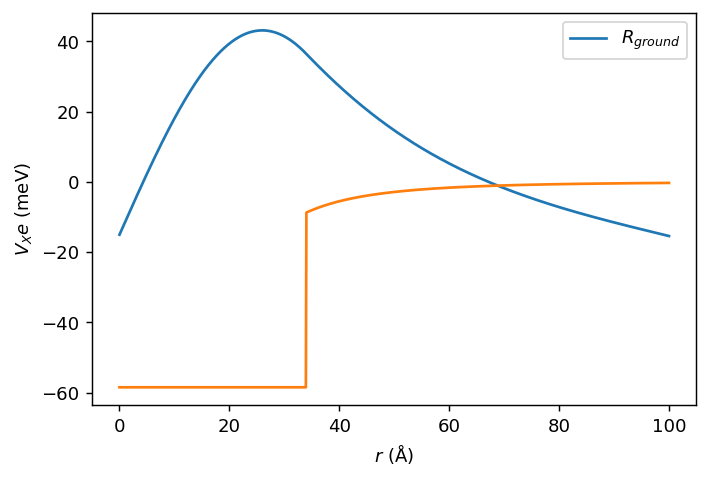

In [116]:
# for i in range(1022,1017,-1):
    
i = 1022
E_i = -(eigenvalues[i] * hbar**2) / (2 * M_red)
plt.plot(r / angstrom, v_0 * unitary[:, i] / (abs(unitary[:, i]).max() * meV) + E_i / meV, label="$R_{ground}$")
print('eigenenergy', i, ':', E_i)
plt.legend()
    
plt.plot(r / angstrom, V_Xe(r) / meV)
ylabel = plt.ylabel(r'$V_Xe$ (meV)')# ' and $R_{ground}$ (arb) ')
plt.xlabel(r'$r$ (Å)')
plt.savefig('state.png')
plt.show()

## Variable Phase Approach for (Schmidt et al.)
### Implementing Eq. (32)
$U(r) = V(r)/U_0$ where $U_0$ is the energy scale $U_0= \hbar^2 / (2m_r r_0)^2$ (in meV).

 * You should make sure that your phase shift is converged with respect to the distance (because it is formally defined when $r>>r_0$). So you can try to plot the phase shift as a function of r for a fixed k to check this. (???)
 

In [29]:
# U_0 = hbar**2 * meV / (2 * M_red * r_0)**2 

# # solve ODE using VPA for multiple k equation (32)
# def ODE_32(delta, r, k, V_0):
#     top = (2 * M_red * V_Xe(r) / U_0) * (np.cos(delta * riccati_jn(0, k * r )) - np.sin(delta * riccati_yn(0, k * r )))**2 ####? 
#     ddelta_dr = -(top / hbar * k ) ######### units of hbar**(-1) ?
#     return ddelta_dr

# # ODEINT solver
# for k_i in k:
#     delta= odeint(ODE_32, 0, r, args=(k_i, v_0))
#     # print accumulation of phase shift:
#     # print(delta[-1])